In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
#silence DEBUG and WARNINGs
import logging
logging.getLogger('poppy').setLevel(logging.ERROR)
# MagAO-X function definitions
from model_kit import magaoxFunctions as mf
import poppy
# for writing files
from datetime import date
print('Last date this notebook was ran: {0}'.format(date.today()))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Last date this notebook was ran: 2021-01-16


CPU times: user 52 s, sys: 8.73 s, total: 1min
Wall time: 26.6 s


Text(0.5, 1.0, 'vAPP plane amplitude (no mask)')

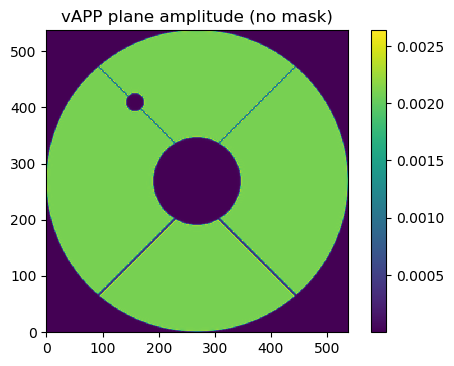

In [5]:
%%time
# load the information
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25}

wavelen = np.round(fr_parm['wavelength'].to(u.nm).value).astype(int)
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2:3}nm'.format(fr_parm['npix'], br, wavelen)

# load the CSV prescription values
home_dir = '/home/jhen/XWCL/code/MagAOX/' # change for exao0
data_dir = home_dir + 'data/'
rx_loc = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}_noap_allopd.csv'.format(parm_name)
rx_sys = mf.makeRxCSV(rx_loc, print_names=False)
n_folder = 10
n_filename = 11

# acquiring csv numerical values for specifically named optics
for t_optic, test_opt in enumerate(rx_sys):
    # remove surfaces for fast Fresnel
    if test_opt['Type'] == 'mirror' or test_opt['Type'] == 'DM': 
        rx_sys[t_optic][n_folder] = 'none' # file folder
        rx_sys[t_optic][n_filename] = 'none' # file name
    if test_opt['Name'] == 'vAPP-trans':
        vappTRANS_num = test_opt['Optical_Element_Number']
        vappOPD_num = vappTRANS_num+1

# vAPP plane analysis to verify pixelscale
rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'
magaox = mf.csvFresnel(rx_csv=rx_sys, 
                       samp=fr_parm['npix'], 
                       oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, 
                       break_plane='vAPP-trans', 
                       bump=True)
vapp_psf, vapp_wf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value, return_final=True)

vapp_amp = poppy.utils.pad_or_crop_to_shape(vapp_wf[0].amplitude, 
                                            (fr_parm['npix'], fr_parm['npix']))
plt.figure(dpi=100)
plt.imshow(vapp_amp, origin='lower')
plt.colorbar()
plt.title('vAPP plane amplitude (no mask)')

In [11]:
vapp_wf[0]._pixelscale_m

<Quantity 1.67763116e-05 m / pix>

### Pad and check fit

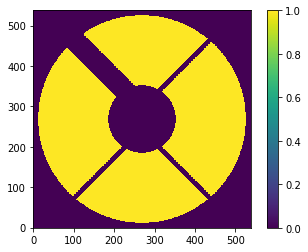

In [6]:
# open the original mask data
vapp_mask = fits.open('MagAOX_pupil_512x512.fits')[0].data
vapp_mask = np.flipud(np.fliplr(vapp_mask)) # flip around because of propagation

mask_pad = poppy.utils.pad_or_crop_to_shape(vapp_mask, 
                                            (fr_parm['npix'], fr_parm['npix']))
plt.imshow(mask_pad, origin='lower')
plt.colorbar()

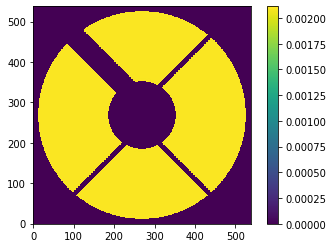

In [8]:
# visual check that it covers the bump and spiders
mask_check = vapp_amp * mask_pad
plt.imshow(mask_check, origin='lower')
plt.colorbar()

In [12]:
# save mask
vAPP_trans_filename = 'vAPP_trans_2PSF_{0}'.format(parm_name)

# Write the transmissive mask
mf.writeTRANSfile(mask_pad, 
                  vapp_wf[0]._pixelscale_m.value, # pixscale must be m/pix coming in 
                  vAPP_trans_filename + '.fits')

### Calculate OPD, save files

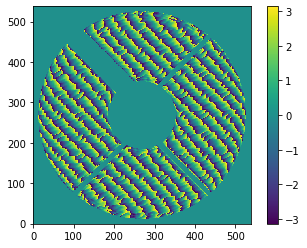

In [13]:
# open the vAPP phase map
vapp_phase = fits.open('MagAOX_vAPP_512x512.fits')[0].data
vapp_phase = np.flipud(np.fliplr(vapp_phase)) # flip around because of propagation
phase_pad = poppy.utils.pad_or_crop_to_shape(vapp_phase, 
                                            (fr_parm['npix'], fr_parm['npix']))

plt.imshow(phase_pad, origin='lower')
plt.colorbar()

In [14]:
# convert to OPD
# save positive phase data
vAPP_posOPD_filename = 'vAPP_opd_2PSF_{0}_posPhase'.format(parm_name)
vapp_2psf_opd_posPhase = 1*(fr_parm['wavelength'].value/(2*np.pi))*phase_pad*mask_pad
mf.writeOPDfile(vapp_2psf_opd_posPhase, 
                vapp_wf[0]._pixelscale_m.value, 
                vAPP_posOPD_filename + '.fits')

# save negative phase data
vAPP_negOPD_filename = 'vAPP_opd_2PSF_{0}_negPhase'.format(parm_name)
vapp_2psf_opd_negPhase = -1*vapp_2psf_opd_posPhase
mf.writeOPDfile(vapp_2psf_opd_negPhase, 
                vapp_wf[0]._pixelscale_m.value, 
                vAPP_negOPD_filename + '.fits')